<a href="https://colab.research.google.com/github/DaudRaza-NUST/DL-Project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> OBJECT DETECTION </center>
### <center> ROBOFLOW GAME DATASET </center>

### Section 1: Exploring the Dataset

Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

2023-12-09 12:29:11.549380: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 12:29:11.959335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 12:29:11.960031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 12:29:12.048880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 12:29:12.273232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 12:29:12.284699: I tensorflow/core/platform/cpu_feature_guard.cc:1

Importing the Roboflow Game Dataset. The Dataset consists of 9.7k images, split into 88% training data, 7% validation data, and 5% testing data. The data has been ported over in the COCO format, which includes the annotations in JSON file format. In order to import the training data, we will use the pycoco API.

In [22]:
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import cv2 as cv

The File has to be opened in the 'Task 1-Object Detection' Folder to work correctly 
 

In [6]:
train = COCO('Dataset/train/_annotations.coco.json')

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


Checking what categories exist in the dataset

In [7]:
cats = train.loadCats(train.getCatIds())

names = [cat['name'] for cat in cats]
print(f"{len(cats)} categories: \n{', '.join(names)}")

6 categories: 
deer-hog, Coyote, Deer, Hog, Rabbit, Raccoon


There are a total of 6 Categories present in the dataset. 
1. Deer-hog
2. Coyote
3. Deer
4. Hog
5. Rabbit
6. Raccoon

In [12]:
# Class Ids
catIds = train.getCatIds()

# Get image Ids
imgIds = train.getImgIds()

# Load images
images = train.loadImgs(imgIds)

print(len(imgIds))
print("imgIds: ", imgIds[0])
print("images: ", images[0])


8453
imgIds:  0
images:  {'id': 0, 'license': 1, 'file_name': '2297271f-4db5-46aa-b92f-efc6a41e19b9_jpg.rf.0003b4e66a75bb5f34b4c94e1cd46e86.jpg', 'height': 430, 'width': 552, 'date_captured': '2023-10-25T23:14:41+00:00'}


The images contain the following information:
1. id
2. license
3. file_name
4. height
5. width
6. date_captured

Now, we import the images themselves in order to better understand the data visually.

In [26]:
img_folder = 'Dataset/train/'
train_imgs = []
for img in images:
    img_path = img_folder + img['file_name']
    train_imgs.append(Image.open(img_path))

We test to see if the dataset has been loaded

8453


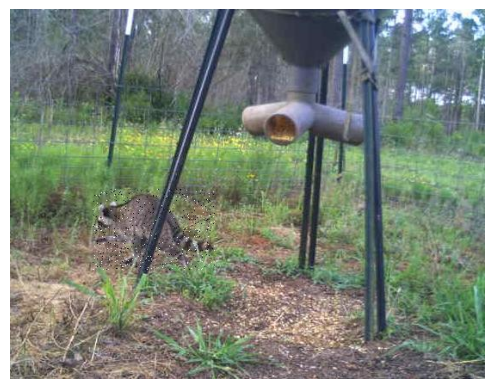

In [45]:
print(len(train_imgs))
plt.imshow(train_imgs[0]), plt.axis('off');

We visualize a random image first

(<matplotlib.image.AxesImage at 0x7f18296d4850>, (-0.5, 551.5, 429.5, -0.5))

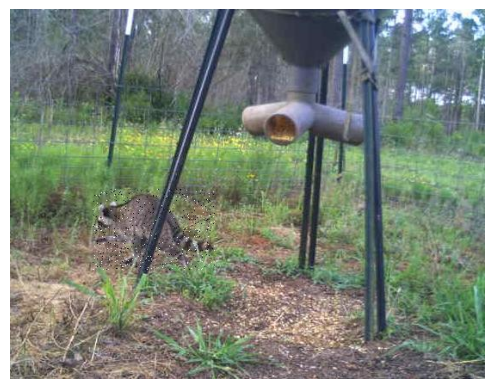

In [224]:
rand_img = images[0]
im = cv.imread(img_folder + rand_img['file_name'])
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im), plt.axis('off')

Then, extracting the bounding box data from the JSON file, we can visualize the image has been annotated. 

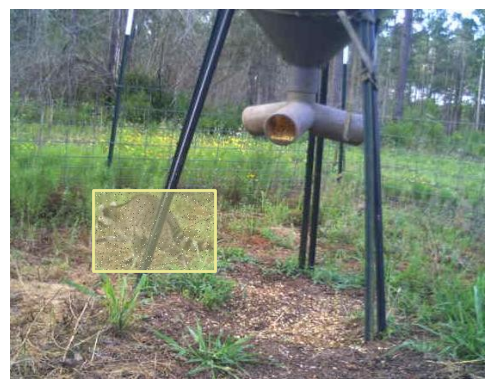

In [225]:
plt.imshow(im); plt.axis('off')
annIds = train.getAnnIds(imgIds=rand_img['id'], iscrowd=None)
anns = train.loadAnns(annIds)
train.showAnns(anns, draw_bbox=True)

In [41]:
# Show bbox labels
[{names[annot['category_id']]: annot['bbox']} for annot in anns]

[{'Deer': [354, 32, 236, 376]}]

The JSON annotation for each image contains:
1. id
2. image_id
3. category_id
4. bbox
5. area
6. segmentation
7. iscrowd

In [40]:
print(anns)

[{'id': 1945, 'image_id': 1357, 'category_id': 2, 'bbox': [354, 32, 236, 376], 'area': 88736, 'segmentation': [], 'iscrowd': 0}]


### Section 2: Data Pre-processing

In this case, our dataset has been fairly pre-processed already. The category Ids are encoded, the bounding boxs have already been created. 

Data augmentation has also been performed in the images. <br />

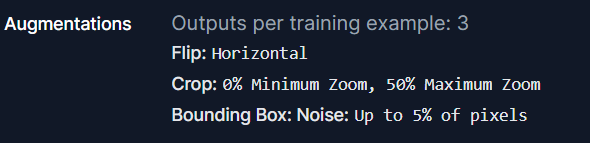

The one thing we do have to verify is the resolution of each image. Considering the plan is to use a Neural Network, the size of the images has to be consistent in order for the convolutions to be possible throughout the layers of the network. 

In [57]:
heights = [images[img]['height'] for img in imgIds]
widths = [images[img]['width'] for img in imgIds]

print("Minimum height:",min(heights), "Minimum Width:",min(widths))
print("Maximum height:",max(heights), "Maximum Width:",max(widths))
print("Mean height:", np.mean(heights), "Standard Deviation:", np.std(heights))
print("Mean width:", np.mean(widths), "Standard Deviation:", np.std(widths))

Minimum height: 116 Minimum Width: 148
Maximum height: 1577 Maximum Width: 2047
Mean height: 553.004495445404 Standard Deviation: 325.11381290834714
Mean width: 713.2291494144091 Standard Deviation: 421.74142161403347


The images dimensions are very spread apart. It will not be possible to use this data without regulating the size of each image to be the same. There are multiple methods of doing so without losing the annotations:

1. Padding (May add too much unnecessory data)
2. Resizing (would require adjusting of the bounding box as well for each image)


#### Resizing Image & Bounding Box

Method#1: Manual Editing

The first method consists of resizing the image to 600x600, and then adjusting the bounding box according to the ratio of the resolution change in x and y. The result is moderately ok, as the full area of the animal is not covered. 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[{'id': 0, 'license': 1, 'file_name': '2297271f-4db5-46aa-b92f-efc6a41e19b9_jpg.rf.0003b4e66a75bb5f34b4c94e1cd46e86.jpg', 'height': 430, 'width': 552, 'date_captured': '2023-10-25T23:14:41+00:00'}, {'id': 1, 'license': 1, 'file_name': 'I__00053_JPG_jpg.rf.00003d1a2a55648b9047b5271b2f5f88.jpg', 'height': 1577, 'width': 2047, 'date_captured': '2023-10-25T23:14:41+00:00'}, {'id': 2, 'license': 1, 'file_name': 'f55d40e7-61f8-41c3-8726-b3c58cc77981_jpg.rf.000836c205411947bd2e21f8ecafaae4.jpg', 'height': 476, 'width': 614, 'date_captured': '2023-10-25T23:14:41+00:00'}, {'id': 3, 'license': 1, 'file_name': 'MDRICKAMER_T_00011_JPG.rf.0012dedcf37e074ebaeb9b3427aa3adb.jpg', 'height': 414, 'width': 534, 'date_captured': '2023-10-25T23:14:41+00:00'}, {'id': 4, 'license': 1, 'file_name': '4d82369a-9aa9-4840-a4ff-cadaba355a77_jpg.rf.001ba255008580e92d35a65a1c9eda87.jpg', 'height': 500, 'width': 644, 'date_captured': '2023-10-25T23:14:41+00:00'}, {'id': 5, 'license': 1,

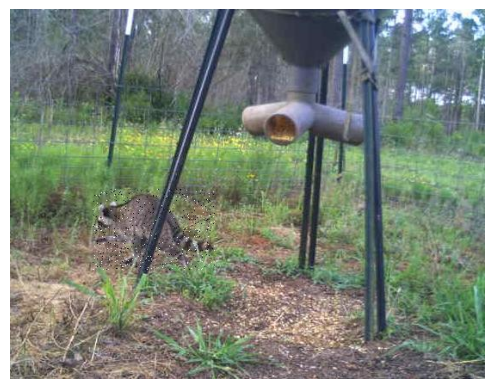

In [188]:
# Create a module for scaling down/scaling up all images to a mean of 600x600
# First, same intial data is copied for testing

test_imgs = train_imgs[:10].copy()
test_data = images[:10].copy()
plt.imshow(test_imgs[0]), plt.axis('off');
ids = [img['id'] for img in test_data]
print(ids)
print(test_data)
print(test_imgs[0].size)

[{'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [96, 210, 142, 94], 'area': 13324.035, 'segmentation': [], 'iscrowd': 0}]


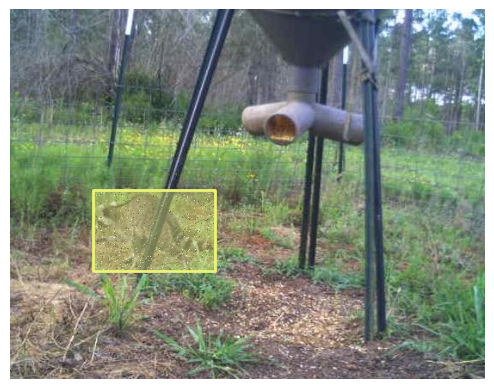

In [211]:
# We plot the data to verify it has been copied correctly

plt.imshow(test_imgs[0]); plt.axis('off')
sample_annIds = train.getAnnIds(imgIds=test_data[0]['id'], iscrowd=None)
sample_anns = train.loadAnns(sample_annIds)
train.showAnns(sample_anns, draw_bbox=True)
print(sample_anns)

In [228]:
# Reset Size
sample_anns[0]['bbox'] = [96, 210, 142, 94]

In [203]:
# Images are scaled

scaled_imgs = [img.resize((600,600)) for img in test_imgs]

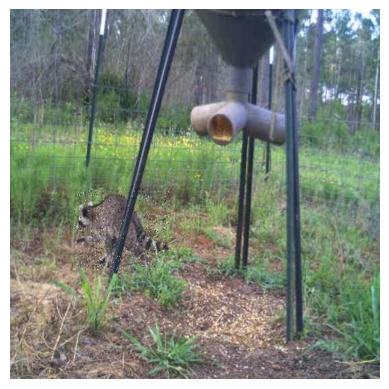

In [204]:
plt.imshow(scaled_imgs[0]), plt.axis('off');

In [226]:
# Scaling the sample img annotation

y_ratio = 600/test_data[0]['height']
x_ratio = 600/test_data[0]['width']
test_anns = sample_anns.copy()
test_anns[0]['bbox'][2] = int(test_anns[0]['bbox'][2]/x_ratio)
test_anns[0]['bbox'][3] = int(test_anns[0]['bbox'][3]/y_ratio)
print(x_ratio,y_ratio)
print(test_anns)
print(scaled_imgs[0].size)

1.0869565217391304 1.3953488372093024
[{'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [96, 210, 130, 67], 'area': 13324.035, 'segmentation': [], 'iscrowd': 0}]
(600, 600)


[{'id': 0, 'image_id': 0, 'category_id': 5, 'bbox': [96, 210, 130, 67], 'area': 13324.035, 'segmentation': [], 'iscrowd': 0}]


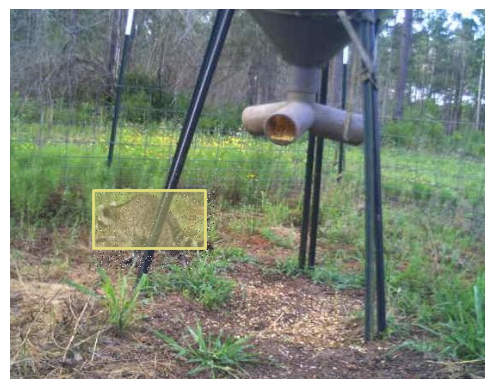

In [227]:
plt.imshow(test_imgs[0]); plt.axis('off')
train.showAnns(test_anns, draw_bbox=True)
print(test_anns)

Method#2: Using Chitra

Chitra is a tool that allows us to resize the bounding box and image at the same time, and is used mainly for Deep learning purposes. However, the way the bounding box has been setup in this dataset does not match the one being used in Chitra. So, when we run it through Chitra, the bounding box does not fit over the image.

In [206]:
from chitra.image import Chitra

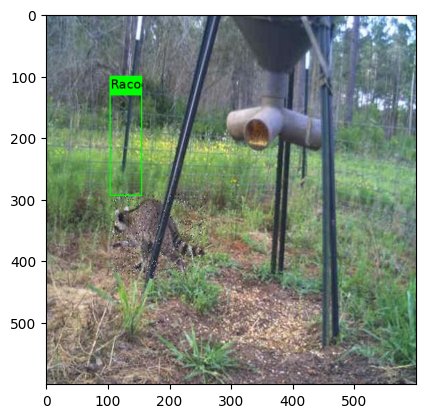

In [209]:
label = 'Racoon'
image = Chitra(test_imgs[0], sample_anns[0]['bbox'], label)
# Chitra can rescale your bounding box automatically based on the new image size.
image.resize_image_with_bbox((600, 600))
plt.imshow(image.draw_boxes())